In [22]:
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from sqlalchemy import MetaData, Table

DB_USER = 'postgres'
DB_PASSWORD = 'pass123'
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'izpo-fifa'

DATABASE_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
        
# https://docs.sqlalchemy.org/en/20/core/reflection.html
engine = create_engine(DATABASE_URL)
metadata_obj = MetaData()
metadata_obj.reflect(bind=engine)

In [23]:
# Load the tables
Player = Table("Player", metadata_obj, autoload_with=engine)
Attempt = Table("Attempt", metadata_obj, autoload_with=engine)
Foul = Table("Foul", metadata_obj, autoload_with=engine)
Game = Table("Game", metadata_obj, autoload_with=engine)
Gameday = Table("Gameday", metadata_obj, autoload_with=engine)
Player = Table("Player", metadata_obj, autoload_with=engine)
Team = Table("Team", metadata_obj, autoload_with=engine)

In [24]:
from sqlalchemy import select

# Build up a statement
stmt = select(Player).where(Player.c.name == "Luka")
print(stmt)

SELECT "Player".id, "Player".name, "Player"."imageUri" 
FROM "Player" 
WHERE "Player".name = :name_1


In [25]:
# We use the following snippet to run the statements
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)

(11, 'Luka', 'https://izpo-fifa.s3.eu-central-1.amazonaws.com/3xRpwjn5J_5Z8rEa8VYco.png')


In [26]:
# Get all the players
stmt = select(Player.c.name, Player.c.id)
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)

('Gregor', 12)
('Miha', 14)
('Jan', 15)
('Domen', 13)
('Luka', 11)


In [27]:
# Get all attempts by user with id=11
stmt = select(Attempt).where(Attempt.c.shooterId == 11).limit(5)
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)


(1, 3, None, True, False, False, 11, 1, None, None, None, None, False)
(2, 6, None, False, False, True, 11, 1, None, None, None, None, False)
(3, 8, 6.0, False, False, False, 11, 1, None, None, None, None, False)
(6, 11, 11.0, True, True, True, 11, 1, None, None, None, None, False)
(7, 11, -4.0, False, False, False, 11, 1, None, None, None, None, False)


# Using Pandas

In [28]:
import pandas as pd

stmt = select(Attempt).where(Attempt.c.shooterId == 11)
with engine.connect() as conn:
    result = conn.execute(stmt)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

print(df.head())

   id  time  distance   goal  penalty  onTarget  shooterId  gameId goalieId  \
0   1   3.0       NaN   True    False     False         11       1     None   
1   2   6.0       NaN  False    False      True         11       1     None   
2   3   8.0       6.0  False    False     False         11       1     None   
3   6  11.0      11.0   True     True      True         11       1     None   
4   7  11.0      -4.0  False    False     False         11       1     None   

   assistedId   x   y  autogoal  
0         NaN NaN NaN     False  
1         NaN NaN NaN     False  
2         NaN NaN NaN     False  
3         NaN NaN NaN     False  
4         NaN NaN NaN     False  


In [29]:
# Create a select statement to get the number of goals scored by each player
# This select returns all the attempts that resulted in a goal
stmt = (
    select(Player.c.id, Player.c.name, Attempt.c.shooterId, Attempt.c.goal)
    .select_from(Player.join(Attempt, Player.c.id == Attempt.c.shooterId))
    .where(Attempt.c.goal == True)
)

# Execute the statement and fetch the rows into a pandas DataFrame
with engine.connect() as conn:
    result = conn.execute(stmt)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Group the data by player and count the number of goals
goals_by_player = df.groupby(["id", "name"]).size().reset_index(name="goals")
print(goals_by_player)

   id    name  goals
0  11    Luka      9
1  12  Gregor     22
2  13   Domen     27
3  14    Miha      6


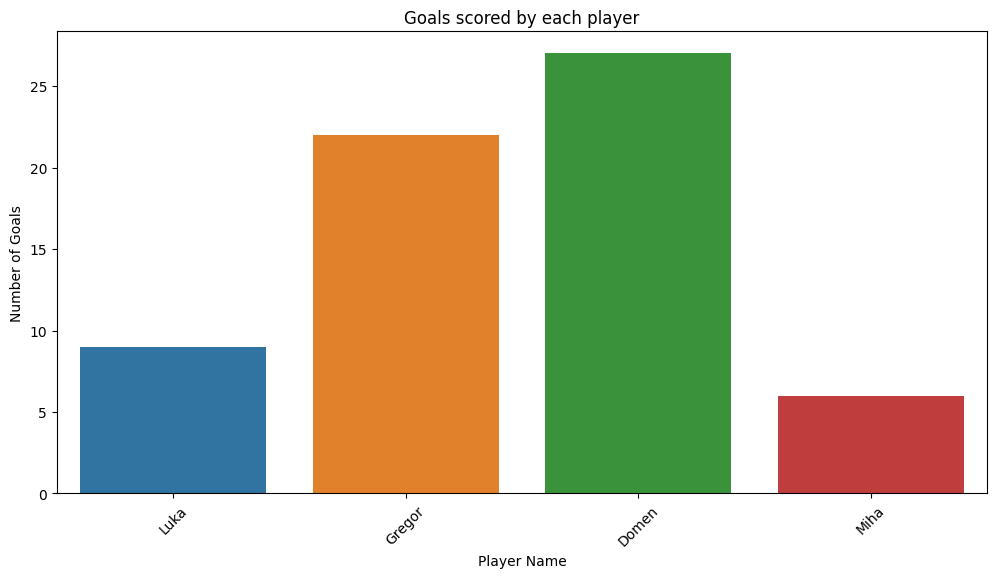

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='goals', data=goals_by_player)

# Set plot labels and title
plt.xlabel('Player Name')
plt.ylabel('Number of Goals')
plt.title('Goals scored by each player')

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Show the plot
plt.show()


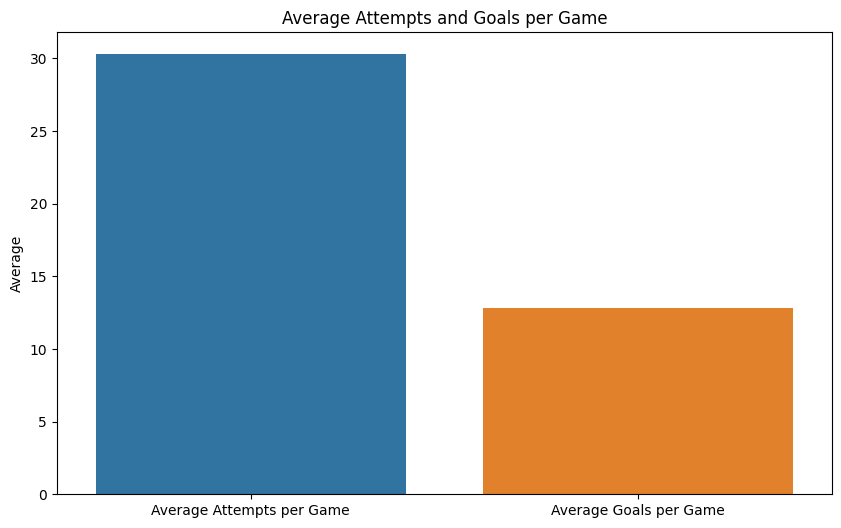

In [33]:
# How many attempts per game average
stmt = select(Attempt.c.id, Attempt.c.gameId, Attempt.c.goal)
with engine.connect() as conn:
    result = conn.execute(stmt)
    df_attempts = pd.DataFrame(result.fetchall(), columns=result.keys())

# Calculate attempts and goals per game
attempts_per_game = df_attempts.groupby("gameId").size().reset_index(name="attempts")
goals_per_game = df_attempts[df_attempts["goal"]].groupby("gameId").size().reset_index(name="goals")

# Calculate average attempts and goals per game
avg_attempts_per_game = attempts_per_game["attempts"].mean()
avg_goals_per_game = goals_per_game["goals"].mean()

# Create a DataFrame for the average values
avg_data = pd.DataFrame(
    {
        "metric": ["Average Attempts per Game", "Average Goals per Game"],
        "value": [avg_attempts_per_game, avg_goals_per_game],
    }
)

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x="metric", y="value", data=avg_data)

# Set plot labels and title
plt.xlabel("")
plt.ylabel("Average")
plt.title("Average Attempts and Goals per Game")

# Show the plot
plt.show()


## Distribution of attempts and goals by time

Right now we get only the attempts which have a time set. If the time is null we don't retrieve them. Alternatively we could and preprocess the data, interpolating the missing values.

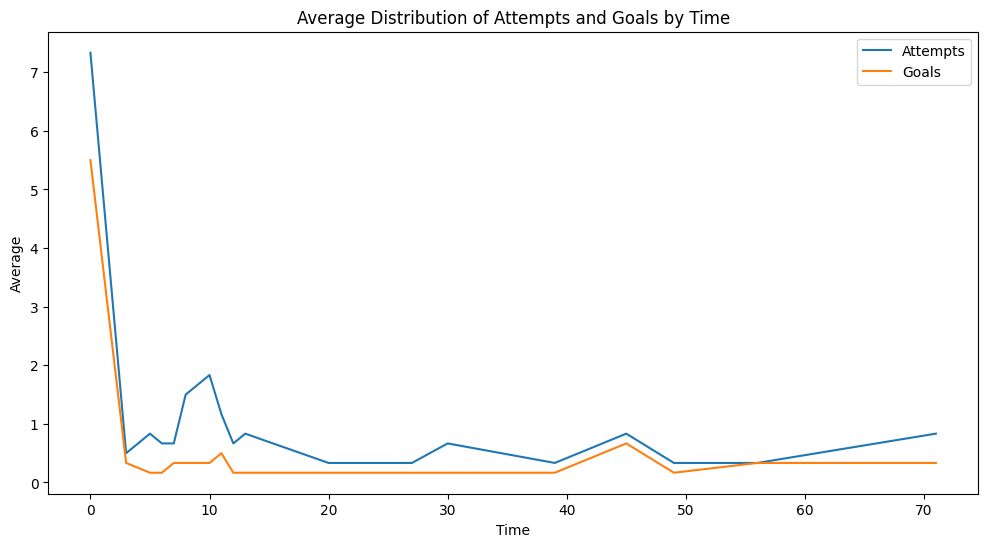

In [36]:
stmt = (
    select(Attempt.c.id, Attempt.c.gameId, Attempt.c.goal, Attempt.c.time)
    .where(Attempt.c.time != None)
)
with engine.connect() as conn:
    result = conn.execute(stmt)
    df_attempts = pd.DataFrame(result.fetchall(), columns=result.keys())

# Group the attempts by the `time` column and count the number of attempts and goals
attempts_by_time = df_attempts.groupby("time").size().reset_index(name="attempts")
goals_by_time = df_attempts[df_attempts["goal"]].groupby("time").size().reset_index(name="goals")

# Merge the dataframes on the `time` column
time_data = pd.merge(attempts_by_time, goals_by_time, on="time")

# Calculate the average number of attempts and goals for each time bucket
total_games = df_attempts["gameId"].nunique()
time_data["avg_attempts"] = time_data["attempts"] / total_games
time_data["avg_goals"] = time_data["goals"] / total_games

# Create a line chart with two lines, one for attempts and one for goals
plt.figure(figsize=(12, 6))
sns.lineplot(x="time", y="avg_attempts", data=time_data, label="Attempts")
sns.lineplot(x="time", y="avg_goals", data=time_data, label="Goals")

# Set plot labels and title
plt.xlabel("Time")
plt.ylabel("Average")
plt.title("Average Distribution of Attempts and Goals by Time")

# Show the legend
plt.legend()

# Show the plot
plt.show()
